### TIME SERIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv('exchange_rate.csv')

In [3]:
df.shape

(7588, 2)

In [4]:
df.head()

,date,Ex_rate
0,01-01-1990 00:00,0.7855
1,02-01-1990 00:00,0.7818
2,03-01-1990 00:00,0.7867
3,04-01-1990 00:00,0.7860
4,05-01-1990 00:00,0.7849


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     7588 non-null   object 
 1   Ex_rate  7588 non-null   float64
dtypes: float64(1), object(1)
memory usage: 118.7+ KB


In [6]:
df.columns

Index(['date', 'Ex_rate'], dtype='object')

In [7]:
df.describe()

,Ex_rate
count,7588.000000
mean,0.776974
std,0.136620
min,0.483297
25%,0.701422
50%,0.761377
75%,0.873477
max,1.102536


In [8]:
z=df.corr(numeric_only=True)        # Correlation matrix
z

,Ex_rate
Ex_rate,1.0


In [11]:
### missing values
df.isnull().sum()

date       0
Ex_rate    0
dtype: int64

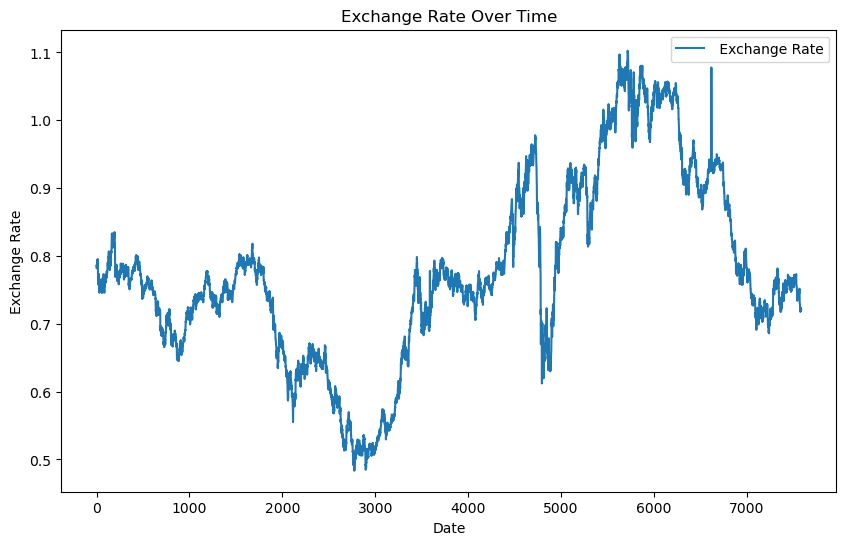

In [13]:
### Plot the time series
plt.figure(figsize=(10,6))
plt.plot(df['Ex_rate'], label=' Exchange Rate')
plt.title('Exchange Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

In [14]:
from scipy.stats import zscore
df['z_score'] = zscore(df['Ex_rate'])
df = df[df['z_score'].abs() < 3]
df.drop(columns=['z_score'], inplace=True)

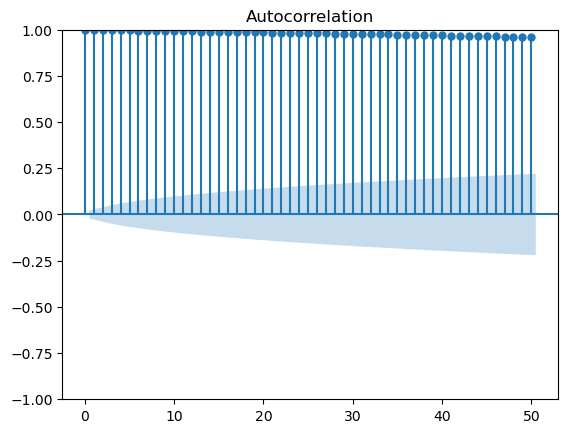

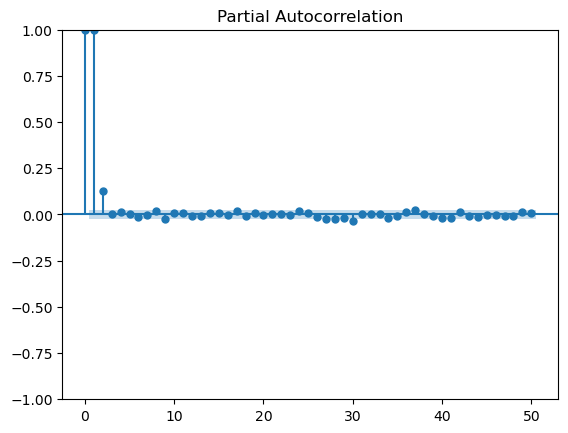

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df['Ex_rate'], lags=50)
plot_pacf(df['Ex_rate'], lags=50)
plt.show()

In [16]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['Ex_rate'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -1.6649941807381343
p-value: 0.44923273535979974


In [17]:
p = 1
d = 1
q = 1

In [18]:
from statsmodels.tsa.arima.model import ARIMA            # developing arima model
model = ARIMA(df['Ex_rate'], order=(p, d, q))
arima_result = model.fit()
print(arima_result.summary())

                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28054.161
Date:                Wed, 05 Nov 2025   AIC                         -56102.322
Time:                        10:35:36   BIC                         -56081.519
Sample:                             0   HQIC                        -56095.182
                               - 7588                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1268      0.045     -2.797      0.005      -0.216      -0.038
ma.L1         -0.0046      0.045     -0.101      0.920      -0.094       0.085
sigma2      3.596e-05   9.94e-08    361.604      0.0

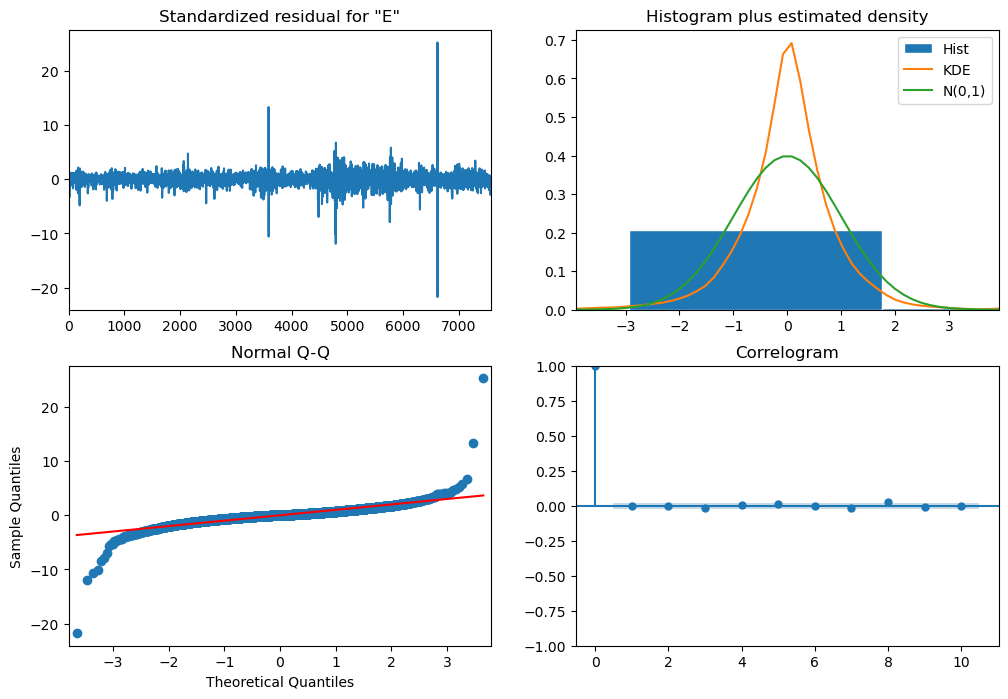

In [19]:
arima_result.plot_diagnostics(figsize=(12, 8))                  # arima model visualization
plt.show()

In [20]:
print(df.index)
print(type(df.index))

RangeIndex(start=0, stop=7588, step=1)
<class 'pandas.core.indexes.range.RangeIndex'>


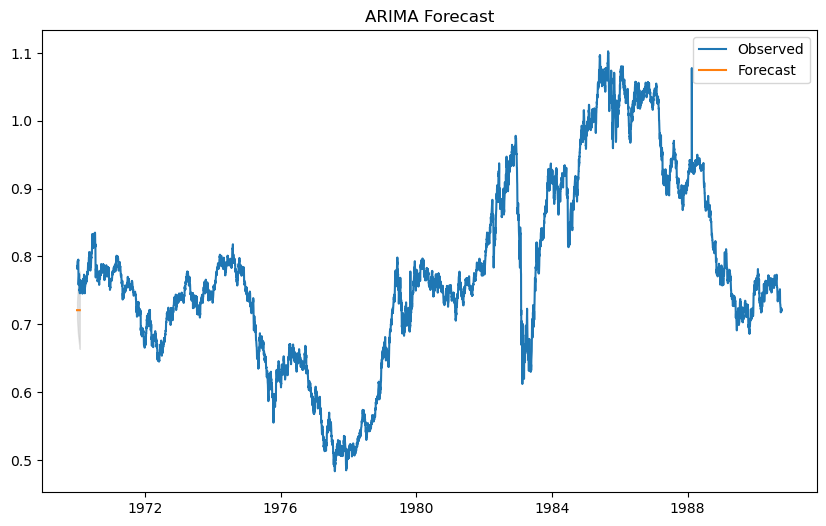

In [23]:
### arima forecast visualization
forecast = arima_result.get_forecast(steps=30)
forecast_index = pd.date_range(df.index[-1], periods=30, freq='D')

forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

plt.figure(figsize=(10, 6))
plt.plot(df['Ex_rate'], label='Observed')
plt.plot(forecast_index, forecast_mean, label='Forecast')
plt.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='gray', alpha=0.2)
plt.title('ARIMA Forecast')
plt.legend()
plt.show()     

In [24]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model_hw = ExponentialSmoothing(df['Ex_rate'], trend='add', seasonal=None)
hw_result = model_hw.fit()
print(hw_result.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                  Ex_rate   No. Observations:                 7588
Model:             ExponentialSmoothing   SSE                              0.273
Optimized:                         True   AIC                         -77641.009
Trend:                         Additive   BIC                         -77613.272
Seasonal:                          None   AICC                        -77640.998
Seasonal Periods:                  None   Date:                 Wed, 05 Nov 2025
Box-Cox:                          False   Time:                         10:42:03
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.8700401                alpha                 True
smoothing_trend             0.0000

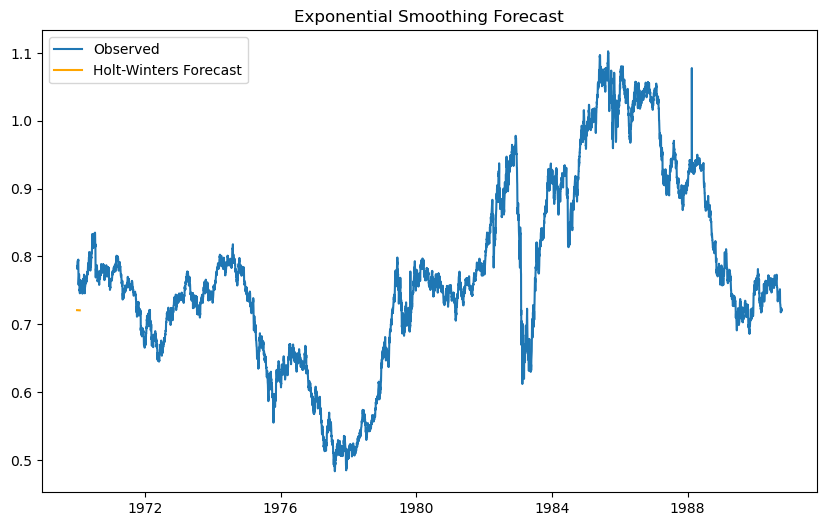

In [25]:
forecast_hw = hw_result.forecast(steps=30)
### exponential smoothing forecast visualization  
plt.figure(figsize=(10, 6))
plt.plot(df['Ex_rate'], label='Observed')
plt.plot(forecast_index, forecast_hw, label='Holt-Winters Forecast', color='orange')
plt.title('Exponential Smoothing Forecast')
plt.legend()
plt.show()  

In [26]:
actual = df['Ex_rate'][-30:]

In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [28]:
mae_arima = mean_absolute_error(actual, forecast_mean)
# Calculate RMSE manually
rmse_arima = np.sqrt(mean_squared_error(actual, forecast_mean))
mae_hw = mean_absolute_error(actual, forecast_hw)
# Calculate RMSE manually
rmse_hw = np.sqrt(mean_squared_error(actual, forecast_hw))

In [29]:
print(f'ARIMA - MAE: {mae_arima}, RMSE: {rmse_arima}')
print(f'Holt-Winters - MAE: {mae_hw}, RMSE: {rmse_hw}')

ARIMA - MAE: 0.012724006489318252, RMSE: 0.016982710912774826
Holt-Winters - MAE: 0.012755742909953578, RMSE: 0.01700521798187411
